## ch4 Compute architecture and scheduling

### 4.1 Architecture of a CUDA-capable GPU

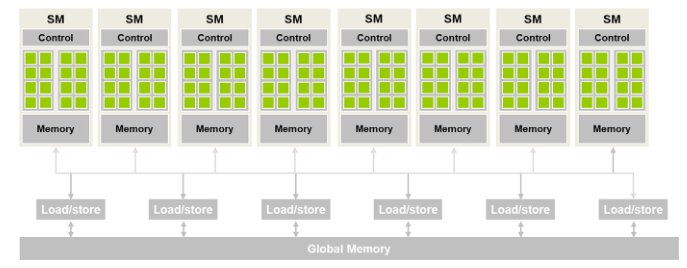

- It is organized into an array of highly threaded **streaming multiprocessors (SMs)**. Each SM has several processing units called streaming processors or CUDA cores  
-  Ampere A100 GPU has 108 SMs with 64 cores each, totaling 6912 cores in the entire GPU.

### 4.2 Block scheduling

#### Thread block assignment to streaming multiprocessors (SMs).

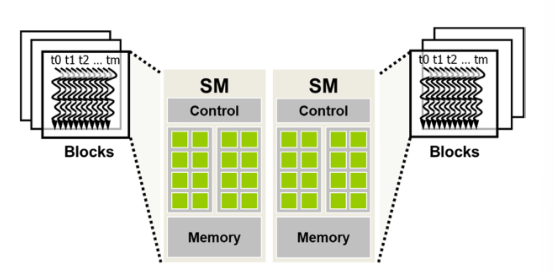

-  threads are assigned to SMs on a block-by-block basis. That is, all threads in a block are simultaneously assigned to the same SM.
- . Multiple blocks are likely to be simultaneously assigned to the same SM.
-  blocks need to reserve hardware resources to execute, so only a limited number of blocks can be simultaneously assigned to a given SM.

The assignment of threads to SMs on a block-by-block basis guarantees that threads in the same block are scheduled simultaneously on the same SM. This guarantee makes it possible for threads in the same block to interact with each other in ways that threads across different blocks cannot. This includes barrier synchronization and accessing a low-latency shared memory that resides on the SM.

### 4.3 Synchronization and transparent scalability

CUDA allows threads in the same block to coordinate their activities using the
barrier synchronization function **__syncthreads()**.  

When a thread calls **__syncthreads()**, it will be held at the pro-
gram location of the call until every thread in the same block reaches that location. This ensures that all threads in a block have completed a phase of their execution before any of them can move on to the next phase.

#### An example execution of barrier synchronization.

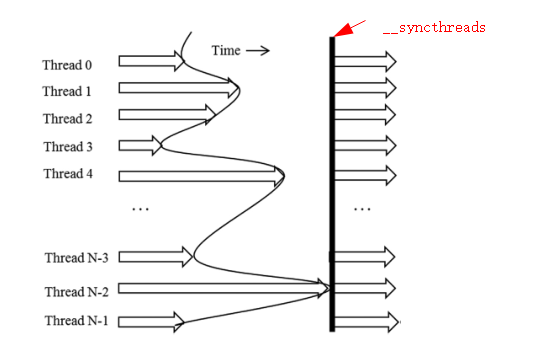

An incorrect use of **__syncthreads()** will cause dead lock.  
if a __syncthreads() statement is present, it must be executed by all
threads in a block. When a __syncthreads() statement is placed in an if statement, either all threads in a block execute the path that includes the __syncthreads() or none of them does. For an if-then-else statement, if each path has a __syncthreads() statement, either all threads in a block execute the then-path or all of them execute the else-path. The two __syncthreads() are different barrier synchronization points.

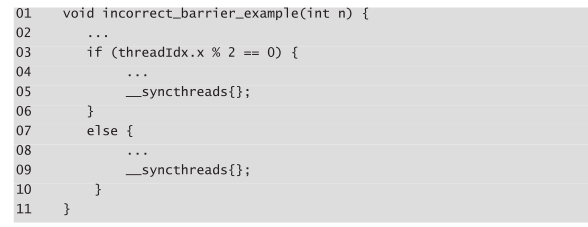

####  transparent scalability
- The ability to execute the same application code on different hardware with different amounts of execution resources.  
- Lack of synchronization constraints between blocks enables transparent scalability for CUDA programs.

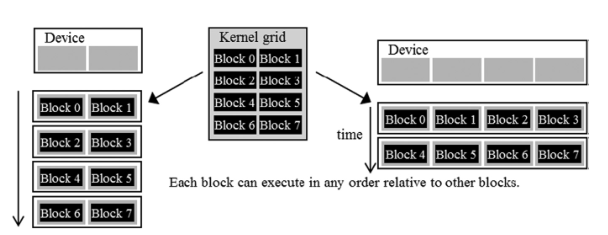

### 4.4 Warps and SIMD hardware

- Once a block has been assigned to an SM, it is further divided into **32-thread** units called **warps**. The size of warps is implementation specific and can vary in future generations of GPUs.  
- A warp is the unit of thread scheduling in SMs.  

Blocks are partitioned into warps for thread scheduling.

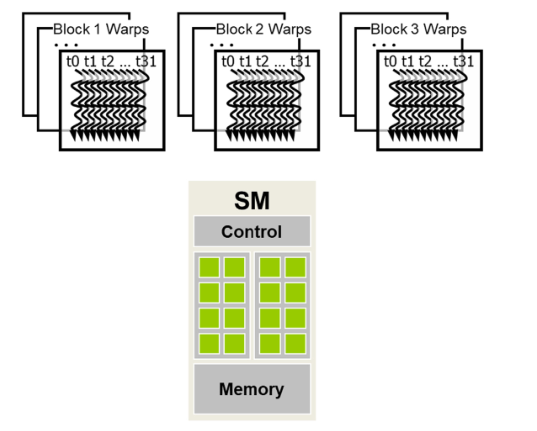

 In this example there are three blocks—Block 1, Block 2, and Block 3—all assigned to an SM. Each of the three blocks is further divided into warps for scheduling purposes. Each warp consists of 32 threads of consecutive threadIdx values: threads 0 through 31 form the first warp, threads 32 through 63 form the second warp, and so on. We can calculate the number of warps that reside in an SM for a given block size and a given number of blocks assigned to each SM. In this example, if each block has 256 threads,
we can determine that each block has 256/32 or 8 warps. With three blocks in the SM, we have 833 = 24 warps in the SM.

####  single-instruction, multiple-data (SIMD) model

An SM is designed to execute all threads in a warp following the single-instruction, multiple-data (SIMD) model. That is, at any instant in time, one instruction is fetched
and executed for all threads in the warp.  

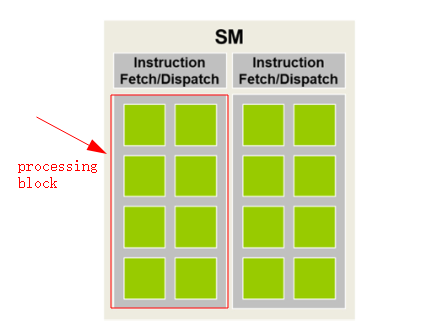

- Above picture shows how the cores in an SM are grouped into processing blocks in which every 8 cores form a processing block and share an instruction fetch/dispatch unit.  
- As a real example, the Ampere A100 SM, which has 64 cores, is organized into four processing blocks with 16 cores each.  
- Threads in the same warp are assigned to the same processing block, which fetches the instruction for the warp and executes it for all threads in the warp at the same time.  
- These threads apply the same instruction to different portions of the data. Because the **SIMD** hardware effectively restricts all threads in a warp to execute the same instruction at any point in time, the execution behavior of a warp is often referred to as single instruction, multiple-thread.

The advantage of SIMD is that the cost of the control hardware, such as the instruction fetch/dispatch unit, is shared across many execution units. This design choice allows for a smaller percentage of the hardware to be dedicated to control and a larger percentage to be dedicated to increasing arithmetic throughput.  

### 4.5 Control divergence
When threads in the same warp follow different execution paths, we say that these threads exhibit control divergence, that is, they diverge in their execution.

#### Example of a warp diverging at an if-else statement.

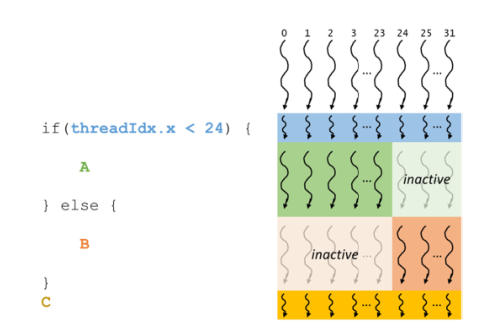

-  In the Pascal architecture and prior architectures, these passes are executed sequentially,meaning that one pass is executed to completion followed by the other pass. 
- From the Volta architecture onwards, the passes may be executed concurrently, meaning that the execution of one pass may be interleaved with the execution of another pass. This feature is referred to as **independent thread scheduling**.

### 4.6 Warp scheduling and latency tolerance

 the hardware can execute instructions only for a subset of all warps in the SM. A legitimate question is why we need to have so many warps assigned to an SM if it can execute only a subset of them at any instant? The answer is that this is how GPUs tolerate long-latency operations such as global memory accesses.

- When an instruction to be executed by a warp needs to wait for the result of a previously initiated long-latency operation, the warp is not selected for execution.  
- Instead, another resident warp that is no longer waiting for results of previous instructions will be selected for execution.  
- If more than one warp is ready for execution, a priority mechanism is used to select one for execution. 
This mechanism of filling the latency time of operations from some threads with work from other threads is often called “**latency tolerance**” or “__latency hiding__”

- For latency tolerance to be effective, it is desirable for an SM to have many more threads assigned to it than can be simultaneously supported with its execution resources to maximize the chance of finding a warp that is ready to executeat any point in time.  
- For example, in an Ampere A100 GPU, an SM has 64 cores but can have up to 2048 threads assigned to it at the same time. Thus the SM can have up to 32 times more threads assigned to it than its cores can support at any given clock cycle.  

so each thread excute on each SM core??  

- This oversubscription of threads to SMs is essential for latency tolerance.  
- It increases the chances of finding another warp to execute when a currently executing warp encounters a long-latency operation.

### 4.7 Resource partitioning and occupancy

####  SM occupancy
**The ratio of the number of warps assigned to an SM to the maximum number it supports**.  

The execution resources in an SM include  
- registers   
- shared memory  
- thread block slots   
- thread slots  

These resources are dynamically partitioned across threads to support their execution. For example, an Ampere A100 GPU can support a maximum of 32 blocks per SM, 64 warps (2048 threads) per SM, and 1024 threads per block.  

This ability to dynamically partition thread slots among blocks makes SMs versatile. They can either execute many blocks each having few threads or execute few blocks each having many threads.  

Dynamic partitioning of resources can lead to subtle interactions between resource limitations, which can cause underutilization of resources. Such interactions can occur between **block slots and thread slots**.

 In the example of the Ampere A100, we saw that the block size can be varied from 1024 to 64, resulting in 2?32 blocks per SM, respectively. In all these cases, the total number of threads assigned to the SM is 2048, which maximizes occupancy. Consider, however, the case when each block has 32 threads. In this case, the 2048 thread slots would need to be partitioned and assigned to 64 blocks. However, the Volta SM can support only 32 blocks slots at once. This means that only 1024 of the thread slots will be utilized, that is, 32 blocks with 32 threads each. The occupancy in this case is (1024 assigned threads)/(2048 maximum threads) = 50%. Therefore to fully utilize the thread slots and achieve maximum occupancy, one needs at least 64 threads in each block.

Another situation that could negatively affect occupancy occurs when the maximum number of threads per block is not divisible by the block size.   
In the example of the Ampere A100, we saw that up to 2048 threads per SM can be supported. However, if a block size of 768 is selected, the SM will be able to accommodate only 2 thread blocks (1536 threads), leaving 512 thread slots unutilized.   
In this case, neither the maximum threads per SM nor the maximum blocks per SM are reached. The occupancy in this case is (1536 assigned threads)/(2,048 maximum threads) = 75%.

 Also be aware of potential impact of register resource and shared memory limitations on SM occupancy!!

### 4.8 Querying device properties

- cudaGetDeviceCount  
- cudaGetDeviceProperties 

#### cudaDeviceProp
- maxThreadsPerBlock: the maximum number of threads allowed in a block in the queried device.  
- multiProcessorCount: The number of SMs in the device  
- clockRate:  the clock frequency of the device  
- maxThreadsDim[0]、maxThreadsDim[1]、maxThreadsDim[2]： the maximum number of threads allowed along each dimension of a block   
- maxGridSize[0]、maxGridSize[1]、maxGridSize[2]： maximum number of blocks allowed along each dimension of a grid  
- regsPerBlock：  the number of registers that are available in each SM  
the maximum number of registers that a block can use is indeed the same as the total number of registers that are available in the SM.  
- warpSize： warp size  